In [1]:
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.8/208.8 MB 3.6 MB/s eta 0:00:0000:0100:02m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 2.4 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 4.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 8.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 16.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 17.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 11.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 186.9/186.9 kB 19.6 MB/s et

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.layers import UpSampling2D
from tensorflow.image import resize

In [2]:
# for mis-matched dimensions, taking them to 256x256

def load_real_data(data_dir, target_size=(256, 256)):
    landslide_dir = os.path.join(data_dir, 'landslide')
    non_landslide_dir = os.path.join(data_dir, 'non-landslide')

    images = []
    dems = []
    masks = []

    # Load landslide data
    for filename in os.listdir(os.path.join(landslide_dir, 'image')):
        if filename.endswith(".png"):
            image_path = os.path.join(landslide_dir, 'image', filename)
            dem_path = os.path.join(landslide_dir, 'dem', filename)
            mask_path = os.path.join(landslide_dir, 'mask', filename)

            image = img_to_array(load_img(image_path))
            dem = img_to_array(load_img(dem_path, color_mode='grayscale'))
            mask = img_to_array(load_img(mask_path, color_mode='grayscale'))

            # Resize image, DEM, and mask
            image = resize(image, target_size)
            dem = resize(dem, target_size)
            mask = resize(mask, target_size)

            # Normalize image and DEM to [0, 1]
            image = image / 255.0
            dem = dem / 255.0
            # Mask is already in [0, 1] if it is binary (0 or 255)
            mask = mask / 255.0 # this was the issue, masks were not binary, so loss was negative due to instability

            images.append(image)
            dems.append(dem)
            masks.append(mask)

    # Load non-landslide data (no masks)
    for filename in os.listdir(os.path.join(non_landslide_dir, 'image')):
        if filename.endswith(".png"):
            image_path = os.path.join(non_landslide_dir, 'image', filename)
            dem_path = os.path.join(non_landslide_dir, 'dem', filename)

            image = img_to_array(load_img(image_path))
            dem = img_to_array(load_img(dem_path, color_mode='grayscale'))

            # Resize image and DEM
            image = resize(image, target_size)
            dem = resize(dem, target_size)

            # Normalize image and DEM to [0, 1]
            image = image / 255.0
            dem = dem / 255.0

            # For non-landslide images, masks will be all zeros
            mask = np.zeros(target_size + (1,), dtype='float32')  # to ensure mask has correct dimensions

            images.append(image)
            dems.append(dem)
            masks.append(mask)

    return np.array(images), np.array(dems), np.array(masks)



In [3]:
data_dir = '/Users/pep/downloads/Bijie_dataset'

images, dems, masks = load_real_data(data_dir)


In [4]:
X_train_img, X_test_img, X_train_dem, X_test_dem, y_train, y_test = train_test_split(images, dems, masks, test_size=0.2, random_state=42)

In [5]:
X_train_img.shape

(2218, 256, 256, 3)

In [6]:
X_train_img[0].shape

(256, 256, 3)

In [7]:
X_train_dem[0].shape

(256, 256, 1)

In [8]:
y_train[0].shape

(256, 256, 1)

In [116]:
y_train[10][166]

array([[0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.   

In [9]:
# def conv_block(input_tensor, num_filters):
#     """convolutional block with Batch Normalization and ReLU activation"""
#     x = layers.Conv2D(num_filters, 3, padding="same")(input_tensor)
#     x = layers.BatchNormalization()(x)
#     x = layers.ReLU()(x)

#     x = layers.Conv2D(num_filters, 3, padding="same")(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.ReLU()(x)

#     return x

# def attention_block(x, shortcut, num_filters):
#     """Attention block to focus on important features"""
#     g1 = layers.Conv2D(num_filters, 1)(x)
#     g1 = UpSampling2D(size=(2,2))(g1)  # Upsample g1 to match the size of x1
#     x1 = layers.Conv2D(num_filters, 1)(shortcut)

#     x2 = layers.Add()([g1, x1])
#     x2 = layers.Activation('relu')(x2)

#     x2 = layers.Conv2D(1, 1)(x2)
#     x2 = layers.Activation('sigmoid')(x2)
#     x2 = layers.Multiply()([shortcut, x2])
#     return x2

# def upsample_concat_block(x, skip):
#     """Upsampling block followed by a concatenation with the skip connection"""
#     x = layers.UpSampling2D((2, 2))(x)
#     #x = layers.UpSampling2D((2, 2))(x)
#     x = layers.Concatenate()([x, skip])
#     return x

# def upsample_concat_block_final(x, skip):
#     """Upsampling block followed by a concatenation with the skip connection for final"""
#     #x = layers.UpSampling2D((2, 2))(x)
#     #x = layers.UpSampling2D((2, 2))(x)
#     x = layers.Concatenate()([x, skip])
#     return x

In [10]:
# def build_unet_model(input_shape_rgb, input_shape_dem):
#     inputs_rgb = layers.Input(input_shape_rgb)
#     inputs_dem = layers.Input(input_shape_dem)

#     # Dual streams
#     c1_rgb = conv_block(inputs_rgb, 16)
#     c1_dem = conv_block(inputs_dem, 8)

#     # Combining dual streams
#     combined = layers.Concatenate()([c1_rgb, c1_dem])

#     # Downscaling
#     c2 = conv_block(combined, 32)
#     p2 = layers.MaxPooling2D((2, 2))(c2)
#     p2 = layers.Dropout(0.1)(p2)

#     c3 = conv_block(p2, 64)
#     p3 = layers.MaxPooling2D((2, 2))(c3)
#     p3 = layers.Dropout(0.1)(p3)

#     c4 = conv_block(p3, 128)
#     p4 = layers.MaxPooling2D((2, 2))(c4)
#     p4 = layers.Dropout(0.1)(p4)

#     # Bottleneck
#     bn = conv_block(p4, 256)

#     # Upscaling
#     a4 = attention_block(bn, c4, 128)
#     u4 = upsample_concat_block(bn, a4)
#     c5 = conv_block(u4, 128)

#     a3 = attention_block(c5, c3, 64)
#     u3 = upsample_concat_block(c5, a3)
#     c6 = conv_block(u3, 64)

#     a2 = attention_block(c6, c2, 32)
#     u2 = upsample_concat_block(c6, a2)
#     c7 = conv_block(u2, 32)

#     # Final upsample and combine with initial combined layer
#     u1 = upsample_concat_block_final(c7, combined)
#     c8 = conv_block(u1, 16)

#     # Output layer
#     outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c8)
#     model = Model(inputs=[inputs_rgb, inputs_dem], outputs=[outputs])

#     return model


In [11]:
# model = build_unet_model((256, 256, 3), (256, 256, 1))  # dimensions
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 16)         448       ['input_1[0][0]']             
                                                                                                  
 conv2d_2 (Conv2D)           (None, 256, 256, 8)          80        ['input_2[0][0]']             
                                                                                              

In [31]:
# model.fit([X_train_img, X_train_dem], y_train, validation_data=([X_test_img, X_test_dem], y_test), batch_size=16, epochs=30)

Epoch 1/30
  2/139 [..............................] - ETA: 8:46 - loss: 0.5723 - accuracy: 0.7413 

KeyboardInterrupt: 

In [ ]:
model.save('landslide_segmentation_model.h5')


In [ ]:
# Part 2: Fetching the attention matrices

In [32]:
def conv_block(input_tensor, num_filters):
    """convolutional block with Batch Normalization and ReLU activation"""
    x = layers.Conv2D(num_filters, 3, padding="same")(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(num_filters, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    return x

def attention_block(x, shortcut, num_filters):
    g1 = layers.Conv2D(num_filters, 1)(x)
    g1 = UpSampling2D(size=(2,2))(g1) 
    x1 = layers.Conv2D(num_filters, 1)(shortcut)

    x2 = layers.Add()([g1, x1])
    x2 = layers.Activation('relu')(x2)

    attention_weights = layers.Conv2D(1, 1)(x2)
    attention_weights = layers.Activation('sigmoid')(attention_weights)
    x2 = layers.Multiply()([shortcut, attention_weights])

    return x2, attention_weights  # Return both output and attention weights

def upsample_concat_block(x, skip):
    """Upsampling block followed by a concatenation with the skip connection"""
    x = layers.UpSampling2D((2, 2))(x)
    #x = layers.UpSampling2D((2, 2))(x)
    x = layers.Concatenate()([x, skip])
    return x

def upsample_concat_block_final(x, skip):
    """Upsampling block followed by a concatenation with the skip connection for final"""
    #x = layers.UpSampling2D((2, 2))(x)
    #x = layers.UpSampling2D((2, 2))(x)
    x = layers.Concatenate()([x, skip])
    return x

In [39]:
def build_unet_model(input_shape_rgb, input_shape_dem):
    inputs_rgb = layers.Input(input_shape_rgb)
    inputs_dem = layers.Input(input_shape_dem)

    # Dual streams
    c1_rgb = conv_block(inputs_rgb, 16)
    c1_dem = conv_block(inputs_dem, 8)

    # Combining dual streams
    combined = layers.Concatenate()([c1_rgb, c1_dem])

    # Downscaling
    c2 = conv_block(combined, 32)
    p2 = layers.MaxPooling2D((2, 2))(c2)
    p2 = layers.Dropout(0.1)(p2)

    c3 = conv_block(p2, 64)
    p3 = layers.MaxPooling2D((2, 2))(c3)
    p3 = layers.Dropout(0.1)(p3)

    c4 = conv_block(p3, 128)
    p4 = layers.MaxPooling2D((2, 2))(c4)
    p4 = layers.Dropout(0.1)(p4)

    # Bottleneck
    bn = conv_block(p4, 256)

    # Upscaling
    a4, attention_weights_a4 = attention_block(bn, c4, 128)
    #a4 = attention_block(bn, c4, 128)
    u4 = upsample_concat_block(bn, a4)
    c5 = conv_block(u4, 128)

    a3, attention_weights_a3 = attention_block(c5, c3, 64)
    u3 = upsample_concat_block(c5, a3)
    c6 = conv_block(u3, 64)

    a2, attention_weights_a2 = attention_block(c6, c2, 32)
    u2 = upsample_concat_block(c6, a2)
    c7 = conv_block(u2, 32)

    # Final upsample and combine with initial combined layer
    u1 = upsample_concat_block_final(c7, combined)
    c8 = conv_block(u1, 16)

    # Output layer
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c8)
    model = Model(inputs=[inputs_rgb, inputs_dem], outputs=[outputs, attention_weights_a4])  # Including attention weights 

    return model


In [58]:
model = build_unet_model((256, 256, 3), (256, 256, 1)) 
model.compile(optimizer='adam',
              loss=['binary_crossentropy', None],  #  ignore attention weights
              metrics={model.output_names[0]: ['accuracy']})  # Only evaluate accuracy for the main output


3


In [133]:
model.fit([X_train_img, X_train_dem], y_train, validation_data=([X_test_img, X_test_dem], y_test), batch_size=16, epochs=10)

Epoch 1/10
139/139 [==============================] - 574s 4s/step - loss: 0.2672 - conv2d_469_loss: 0.2672 - conv2d_469_accuracy: 0.9590 - val_loss: 0.2234 - val_conv2d_469_loss: 0.2234 - val_conv2d_469_accuracy: 0.9719
Epoch 2/10
139/139 [==============================] - 572s 4s/step - loss: 0.1472 - conv2d_469_loss: 0.1472 - conv2d_469_accuracy: 0.9703 - val_loss: 0.1640 - val_conv2d_469_loss: 0.1640 - val_conv2d_469_accuracy: 0.9719
Epoch 3/10
139/139 [==============================] - 572s 4s/step - loss: 0.1188 - conv2d_469_loss: 0.1188 - conv2d_469_accuracy: 0.9704 - val_loss: 0.1142 - val_conv2d_469_loss: 0.1142 - val_conv2d_469_accuracy: 0.9712
Epoch 4/10
139/139 [==============================] - 558s 4s/step - loss: 0.1073 - conv2d_469_loss: 0.1073 - conv2d_469_accuracy: 0.9706 - val_loss: 0.1126 - val_conv2d_469_loss: 0.1126 - val_conv2d_469_accuracy: 0.9703
Epoch 5/10
139/139 [==============================] - 564s 4s/step - loss: 0.1033 - conv2d_469_loss: 0.1033 - conv2d

In [135]:
model.save('landslide_segmentation_model.keras')

In [174]:
input_img = np.expand_dims(X_train_img[202], axis=0)  # Add batch dimension, X_train_img[10] is landslide instance
input_dem = np.expand_dims(X_train_dem[202], axis=0)  # Add batch dimension

prediction, attention_weights = model.predict([input_img, input_dem])

1/1 [==============================] - 0s 86ms/step


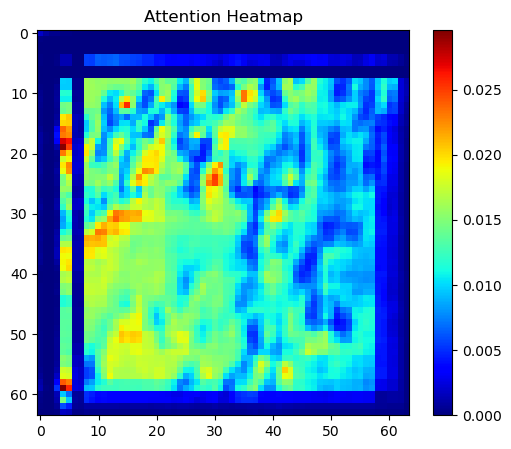

In [175]:
import matplotlib.pyplot as plt

def plot_attention_heatmap(attention_weights, title="Attention Heatmap"):
    plt.figure(figsize=(6, 5))
    attention_weights = attention_weights.squeeze()  # toremove any singleton dimensions
    plt.imshow(attention_weights, cmap='jet', aspect='auto', interpolation='nearest')
    plt.colorbar()
    plt.title(title)
    plt.show()

plot_attention_heatmap(attention_weights[0])  # If batched, index into it


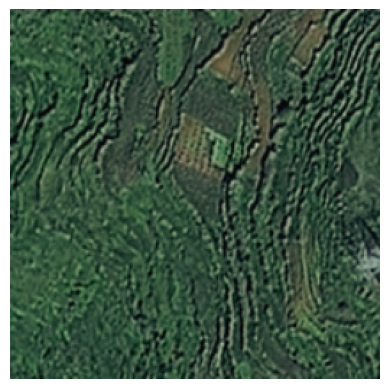

In [176]:
plt.imshow(X_train_img[202]) 
plt.axis('off')  # to hide the axis
plt.show()

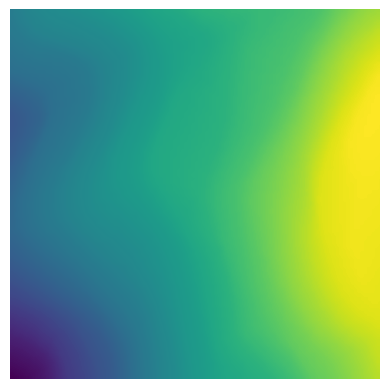

In [177]:
plt.imshow(X_train_dem[202])
plt.axis('off')  # to hide the axis
plt.show()

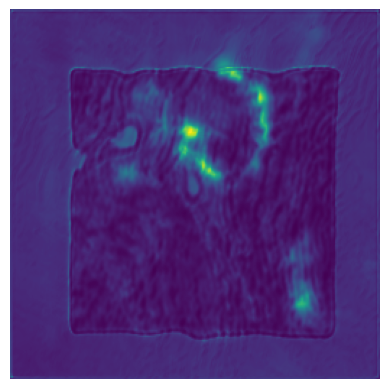

In [178]:
plt.imshow(prediction.squeeze())
plt.axis('off')  # to hide the axis
plt.show()

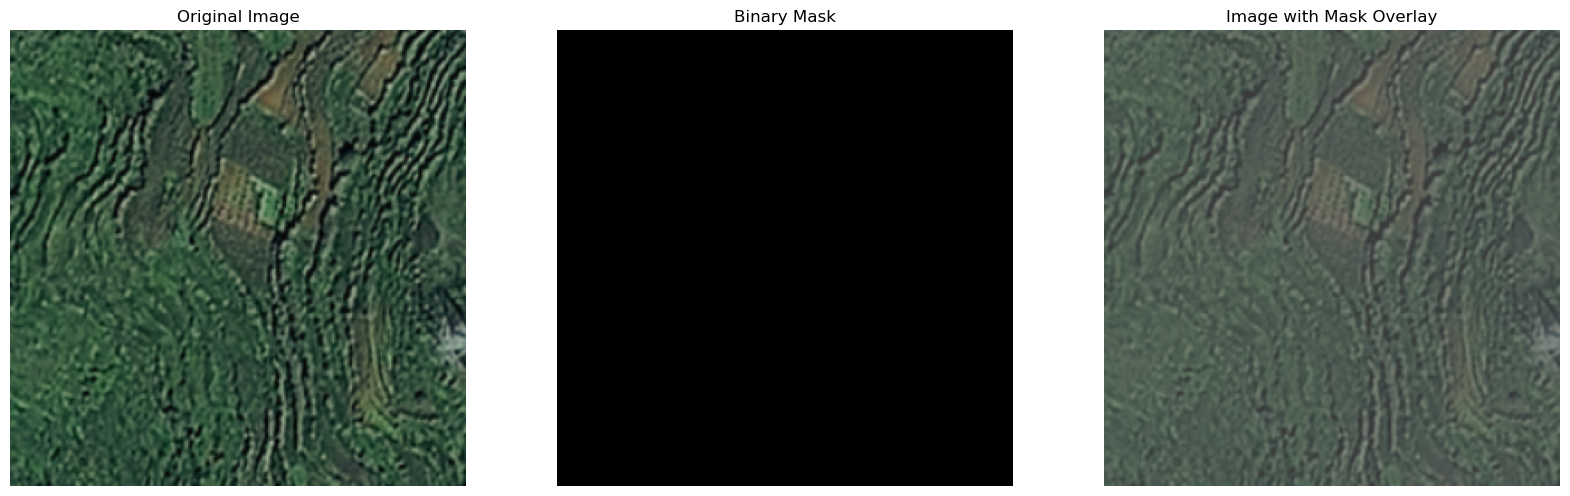

In [179]:
def visualize_mask(image, mask):
    # image is a numpy array of shape (height, width, channels)
    # and mask is a binary mask of shape (height, width) with the same spatial dimensions as the image

    fig, ax = plt.subplots(1, 3, figsize=(20, 10))
    
    # Show original image
    ax[0].imshow(image)
    ax[0].set_title('Original Image')
    ax[0].axis('off')
    
    # Show binary mask
    ax[1].imshow(mask, cmap='gray')
    ax[1].set_title('Binary Mask')
    ax[1].axis('off')
    
    # Show image and mask overlay
    ax[2].imshow(image, alpha=0.7)
    ax[2].imshow(mask, cmap='gray', alpha=0.3)  # Adjust alpha to taste
    ax[2].set_title('Image with Mask Overlay')
    ax[2].axis('off')

    plt.show()

visualize_mask(X_train_img[202], y_train[20])


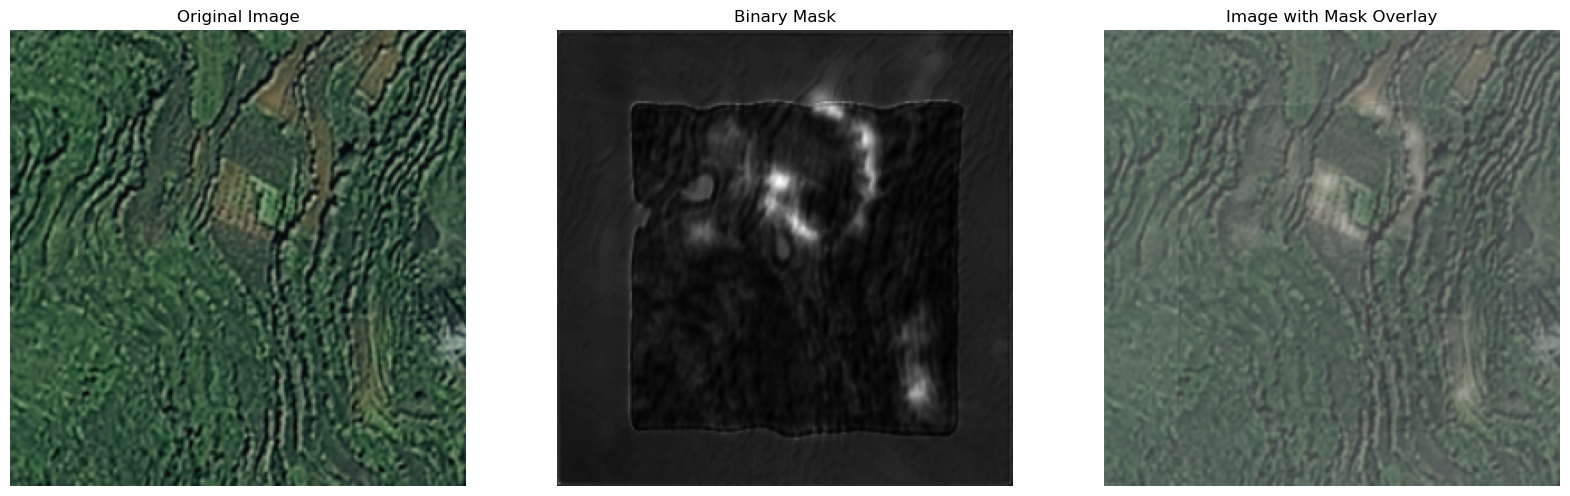

In [180]:
visualize_mask(X_train_img[202], prediction.squeeze()) # this is the behaviour of the model after one epoch (untrained)